In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


**> Let's give a first look at the data!**

In [2]:
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Info

In [3]:
Total_NaN_B = train.isna().sum().sum()
print(f"Missing Values: {train.isna().sum().sum()}")
print(f"Duplicates: {train.duplicated().sum()}")

Missing Values: 2324
Duplicates: 0


In [4]:
Before_C_S = train.isna().sum().values
before_C = (train.drop(columns = ["Name","VIP"]).dropna(how="any", axis = "index")).shape[0]
Tot_NaN_WHT_B = train.drop(columns = ["Name","VIP"]).isna().sum().sum()

train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

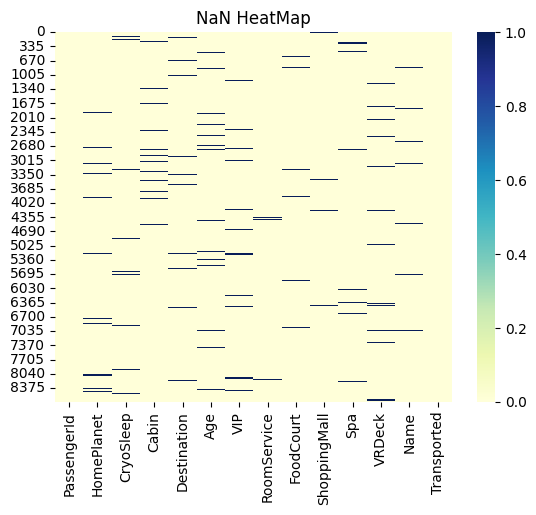

In [5]:
sns.heatmap(train.isna(), cmap = "YlGnBu")
plt.title("NaN HeatMap")
plt.show()

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


The distribution of the VIP column is highly imbalanced, with a significantly larger proportion of non-VIP entries compared to VIP ones. This imbalance could potentially hinder the model's ability to learn meaningful patterns related to VIP status.

Given this skewed distribution, we may consider **dropping the VIP feature** in future iterations of the model, especially if it does not contribute positively to predictive performance.

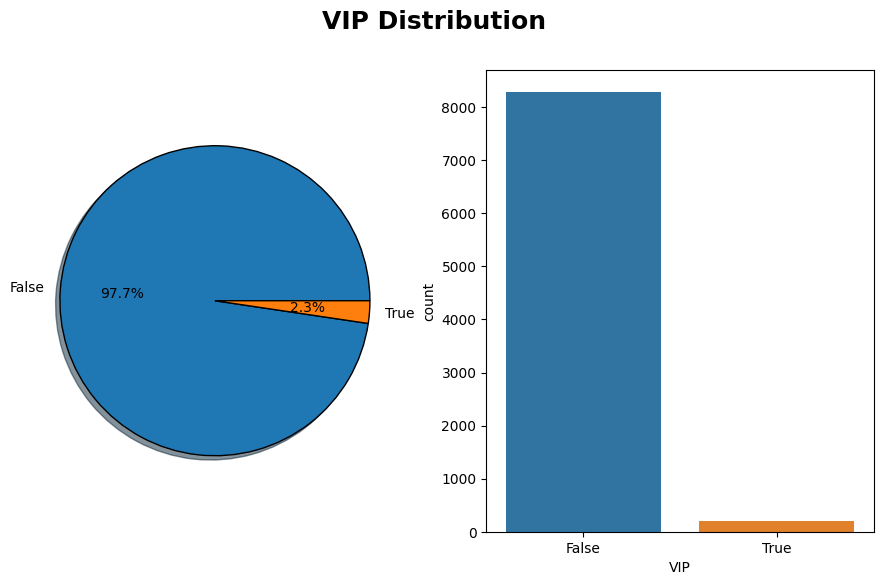

In [7]:
fig, (ax1, ax2) =  plt.subplots(ncols = 2, nrows = 1, figsize = (11, 6))

ax1.pie(train["VIP"].value_counts(), 
        autopct = '%1.1f%%', wedgeprops = {"edgecolor": "black"}, 
        labels = ["False","True"], shadow = True)

sns.countplot(data = train, x = "VIP", ax = ax2)

plt.suptitle("VIP Distribution", fontsize = 18, weight = "bold")
plt.show()

The **Transported** column, which serves as the target variable for classification, is **well-balanced** between its two classes. This balanced distribution is beneficial for training classification models, as it reduces the risk of bias toward one class and allows the model to learn patterns from both outcomes more effectively.

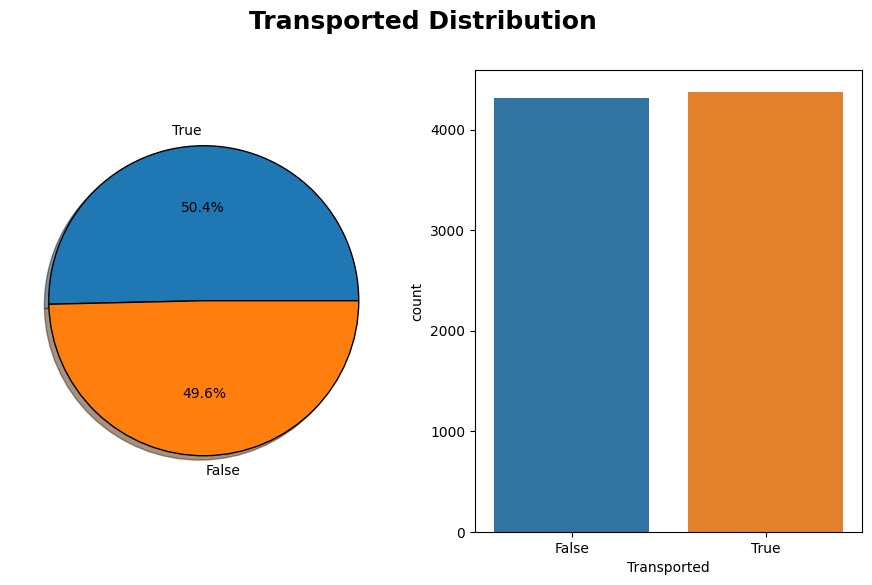

In [8]:
fig, (ax1, ax2) =  plt.subplots(ncols = 2, nrows = 1, figsize = (11, 6))

ax1.pie(train["Transported"].value_counts(), 
        autopct = '%1.1f%%', wedgeprops = {"edgecolor": "black"}, 
        labels = ["True","False"], shadow = True)

sns.countplot(data = train, x = "Transported", ax = ax2)

plt.suptitle("Transported Distribution", fontsize = 18, weight = "bold")
plt.show()

The **correlation heatmap** reveals that most features have correlation values **close to zero**, indicating **weak linear relationships** between them.



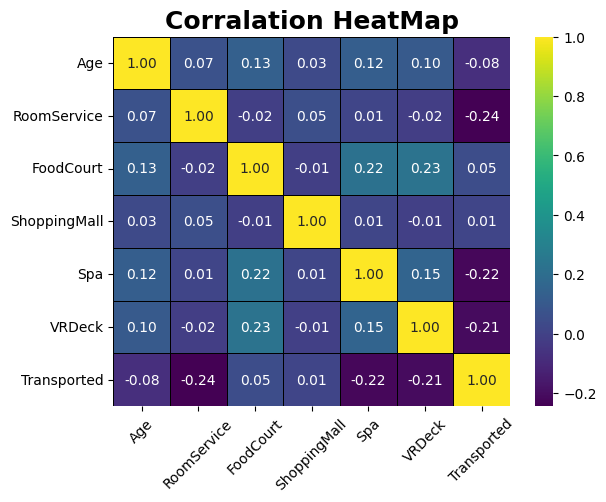

In [9]:
sns.heatmap(train.corr(numeric_only = True), annot = True, fmt = ".2f", cmap = "viridis", linewidth = 0.5, linecolor = "black")
plt.xticks(rotation = 45)
plt.title("Corralation HeatMap", fontdict = {"fontsize": 18, "weight": "bold"})
plt.show()

# Cleaning Data

> Before building any predictive model, it's essential to clean the dataset to ensure data quality and consistency. Cleaning helps eliminate noise, handle missing values, and prepare features for analysis.

Much of this process involves working with **median and mean values**, especially when imputing missing data. However, the most critical aspect of data cleaning is not just **what we replace**, but **what we preserve**. Retaining the **underlying structure and meaningful signals** in the data is key to building models that generalize well and make accurate predictions.

To simplify the Age feature and reduce noise, we grouped it into discrete intervals using **pandas.qcut()**. This method divides the continuous age values into **quantile-based bins**, ensuring that each group contains approximately the same number of observations.

In [10]:
train["Age"] = pd.qcut(train["Age"], q = 4, labels = ["0-19","20-27","28-38","39-79"]).astype(object)
train["Age"].head()

0    39-79
1    20-27
2    39-79
3    28-38
4     0-19
Name: Age, dtype: object

The **CryoSleep** column indicates whether a passenger was in cryogenic sleep during the voyage. Upon exploratory analysis, a clear pattern emerged: Passengers with **CryoSleep = True** **tend to have all expenditure features (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck) equal to 0**.

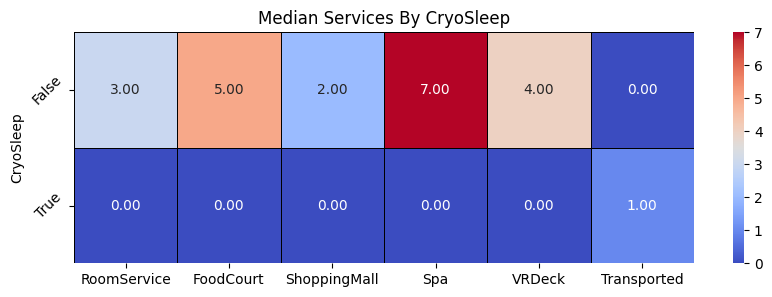

In [11]:
plt.figure(figsize = (10, 3))
sns.heatmap(train.groupby("CryoSleep").median(numeric_only=True), 
            annot = True, fmt = ".2f", linewidth = 0.5, linecolor = "black", cmap = "coolwarm")
plt.title("Median Services By CryoSleep")
plt.yticks(rotation = 45)
plt.show()

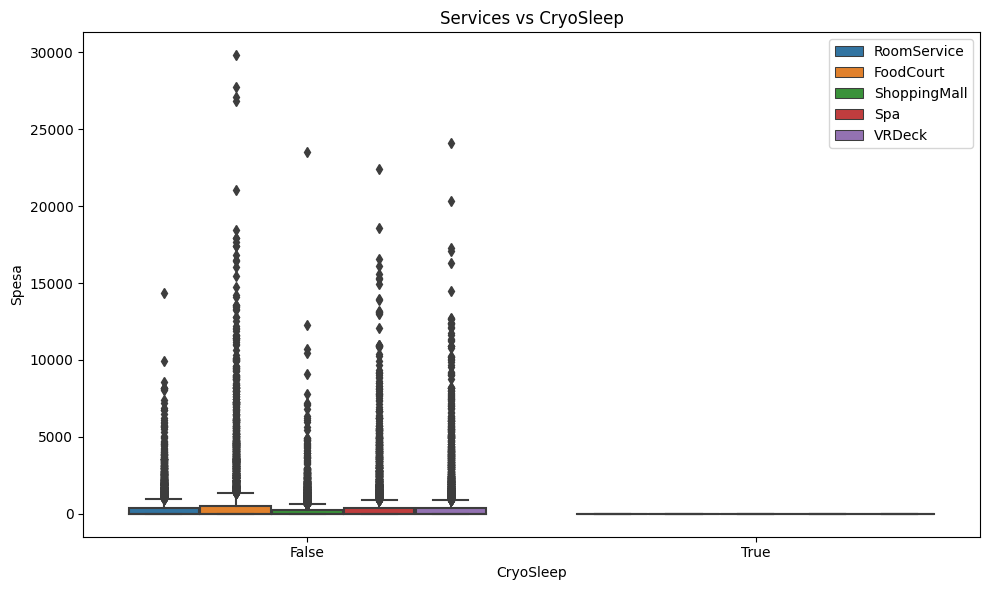

In [12]:
cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

train_melt = train.melt(
    id_vars="CryoSleep",
    value_vars=cols,
    var_name="Service",
    value_name="Spesa"
)

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=train_melt,
    x="CryoSleep",
    y="Spesa",
    hue="Service"
)

plt.title("Services vs CryoSleep")

plt.legend()
plt.tight_layout()
plt.show()

This suggests that those in cryosleep likely did not use any onboard services, which aligns with the expected behavior. Based on this insight:


* I treated CryoSleep as a highly informative feature, potentially linked to inactivity and zero spending.
* For missing values in CryoSleep, I applied a logical imputation: If all spending features were 0, I inferred that CryoSleep was likely True.


In [13]:
nan_count = train[cols].isna().sum(axis=1)

spend_filled = train[cols].fillna(0)
mask_spend_gt0    = spend_filled.gt(0).any(axis=1)
mask_all_zero     = spend_filled.eq(0).all(axis=1)

mask_max_one_nan  = nan_count <= 1
mask_zero_le1nan  = mask_all_zero & mask_max_one_nan
 
train.loc[mask_spend_gt0 & train["CryoSleep"].isna(), "CryoSleep"] = False
train.loc[mask_zero_le1nan & train["CryoSleep"].isna(), "CryoSleep"] = True

print(f"Remaining CryoSleep NaN: {train['CryoSleep'].isna().sum()}")

Remaining CryoSleep NaN: 0


During data exploration, I noticed that the **first four digits** of the PassengerId appear to represent a **group or family unit**. For example, passengers with IDs like 1234_01, 1234_02, etc., likely belong to the same group.

To leverage this insight:

* I extracted the first four digits and created a new feature called **GroupID**.

* This feature helps capture potential correlations,assuming that passengers in the same group may share similar outcomes or behaviors.

* It also allows the model to consider social or familial influence, which might be relevant in scenarios like shared cabins or collective decisions.

In [14]:
train["GroupID"] = train["PassengerId"].str[:4]
train.groupby("GroupID").filter(lambda a: len(a) > 1)[["PassengerId","GroupID","Name", "HomePlanet","Cabin","Destination"]]

,PassengerId,GroupID,Name,HomePlanet,Cabin,Destination
2,0003_01,0003,Altark Susent,Europa,A/0/S,TRAPPIST-1e
3,0003_02,0003,Solam Susent,Europa,A/0/S,TRAPPIST-1e
6,0006_01,0006,Billex Jacostaffey,Earth,F/2/S,TRAPPIST-1e
7,0006_02,0006,Candra Jacostaffey,Earth,G/0/S,TRAPPIST-1e
9,0008_01,0008,Erraiam Flatic,Europa,B/1/P,55 Cancri e
...,...,...,...,...,...,...
8685,9275_01,9275,Polaton Conable,Europa,A/97/P,TRAPPIST-1e
8686,9275_02,9275,Diram Conable,Europa,A/97/P,TRAPPIST-1e
8687,9275_03,9275,Atlasym Conable,Europa,A/97/P,TRAPPIST-1e
8691,9280_01,9280,Celeon Hontichre,Europa,E/608/S,55 Cancri e


To validate whether passengers grouped under the same **GroupID** truly share meaningful characteristics, we examined whether they have the same:

* **HomePlanet**
* **Cabin**
* **Destination**
* **CryoSleep status**

In [15]:
consistency_check_HP = train.groupby('GroupID')['HomePlanet'].nunique().map(lambda x: "Yes" if x == 1 else "No").value_counts()
consistency_check_Ca = train.groupby('GroupID')['Cabin'].nunique().map(lambda x: "Yes" if x == 1 else "No").value_counts()
consistency_check_De = train.groupby('GroupID')['Destination'].nunique().map(lambda x: "Yes" if x == 1 else "No").value_counts()
consistency_check_Cr = train.groupby('GroupID')['CryoSleep'].nunique().map(lambda x: "Yes" if x == 1 else "No").value_counts()



If the **majority of passengers within a group share the same values** for these features, especially by a significant margin, we can reasonably generalize the group behavior. This would support the idea that GroupID captures more than just a numerical label—it reflects shared context or relationships that may influence outcomes.

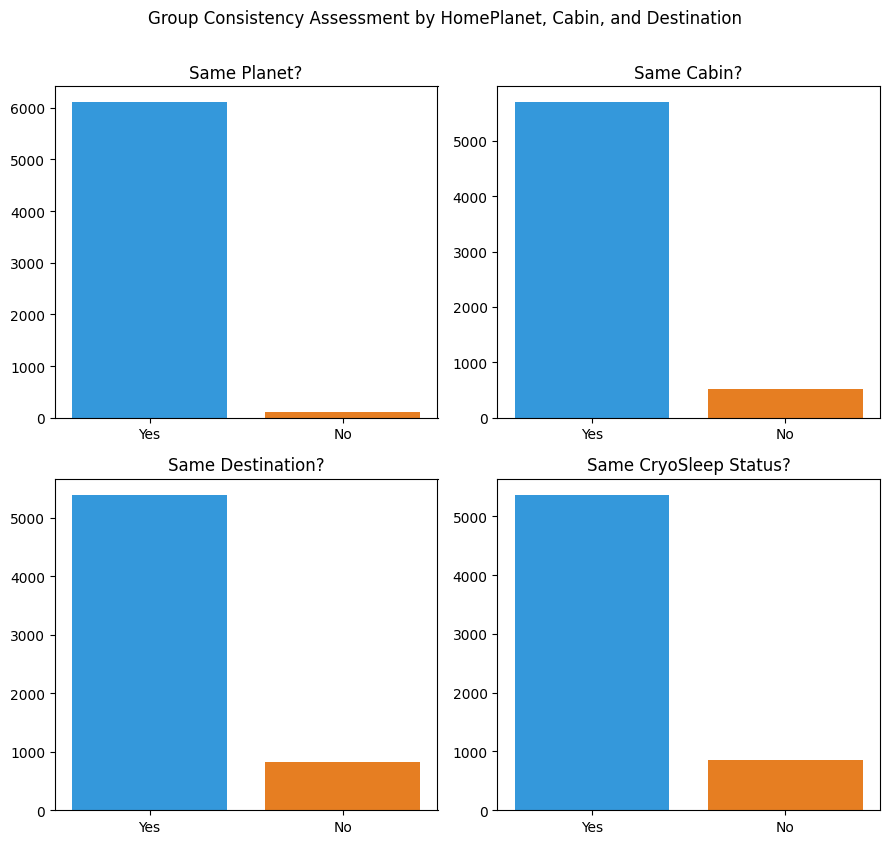

In [16]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 8))
ax1, ax2, ax3, ax4 = axs.flatten()

ax1.bar(consistency_check_HP.index, consistency_check_HP.values, color = ["#3498db","#e67e22"])
ax1.set_title("Same Planet?")

ax2.bar(consistency_check_Ca.index, consistency_check_Ca.values, color = ["#3498db","#e67e22"])
ax2.set_title("Same Cabin?")

ax3.bar(consistency_check_De.index, consistency_check_De.values, color = ["#3498db","#e67e22"])
ax3.set_title("Same Destination?")

ax4.bar(consistency_check_Cr.index, consistency_check_Cr.values, color = ["#3498db","#e67e22"])
ax4.set_title("Same CryoSleep Status?")

plt.tight_layout()
plt.suptitle("Group Consistency Assessment by HomePlanet, Cabin, and Destination", y = 1.05)
plt.show()

The majority of groups show strong consistency across these features, **we can confidently generalize this pattern**.

In [17]:
dest_mapping = train[train['Destination'].notna()].groupby('GroupID')['Destination'].agg(lambda x: x.mode()[0])
homeP_mapping = train[train['HomePlanet'].notna()].groupby('GroupID')['HomePlanet'].agg(lambda x: x.mode()[0])
Cabin_mapping = train[train['Cabin'].notna()].groupby('GroupID')['Cabin'].agg(lambda x: x.mode()[0])

train['Destination'] = train.apply(lambda row1: dest_mapping[row1['GroupID']] if pd.isna(row1['Destination']) and row1['GroupID'] in dest_mapping else row1['Destination'],axis=1)
train['HomePlanet'] = train.apply(lambda row2: homeP_mapping[row2['GroupID']] if pd.isna(row2['HomePlanet']) and row2['GroupID'] in homeP_mapping else row2['HomePlanet'],axis=1)
train['Cabin'] = train.apply(lambda row3: Cabin_mapping[row3['GroupID']] if pd.isna(row3['Cabin']) and row3['GroupID'] in Cabin_mapping else row3['Cabin'],axis=1)

print(f'Remaining Destination NaN: {train["Destination"].isna().sum()}')
print(f'Remaining HomePlanet NaN: {train["HomePlanet"].isna().sum()}')
print(f'Remaining Cabin NaN: {train["Cabin"].isna().sum()}')

Remaining Destination NaN: 103
Remaining HomePlanet NaN: 111
Remaining Cabin NaN: 99


We noticed that when passengers share the same Cabin, often only one person pays for RoomService.

This suggests a shared expense behavior within cabins—possibly one person covers the cost for the entire cabin.

> 📌 **Assumption**: If passengers are in the same cabin and one has a non-zero RoomService charge, we can reasonably assume the others benefited from it too.

In [18]:
train.loc[train["Cabin"].notna(), 'RoomService'] = (
    train.loc[train["Cabin"].notna()].groupby('Cabin')['RoomService']
         .transform(lambda g: g.fillna(0) if (g.fillna(0) > 0).any() else g))

print(f'Remaining RoomService NaN: {train["RoomService"].isna().sum()}')

Remaining RoomService NaN: 156


We can now generalize the **Cabin column** by extracting its first letter, which appears to represent a shared group or deck.

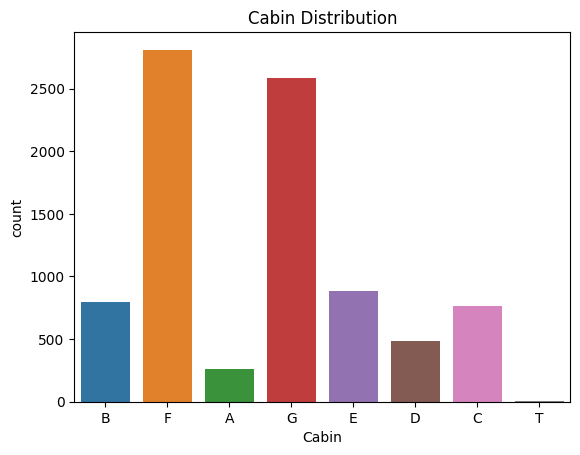

In [19]:
train.loc[train["Cabin"].notna(), "Cabin"] = [c[0] for c in train.loc[train["Cabin"].notna(), "Cabin"]]
sns.countplot(data=train, x = train["Cabin"])
plt.title("Cabin Distribution")
plt.show()

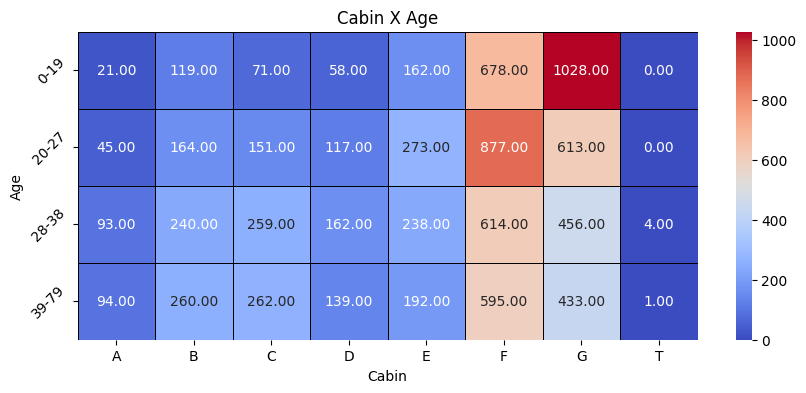

In [20]:
plt.figure(figsize = (10, 4))
sns.heatmap(train.groupby("Age")["Cabin"].value_counts().unstack().fillna(0), 
            annot = True, fmt = ".2f", linewidth = 0.5, linecolor = "black", cmap = "coolwarm")
plt.title("Cabin X Age")
plt.yticks(rotation = 45)
plt.show()

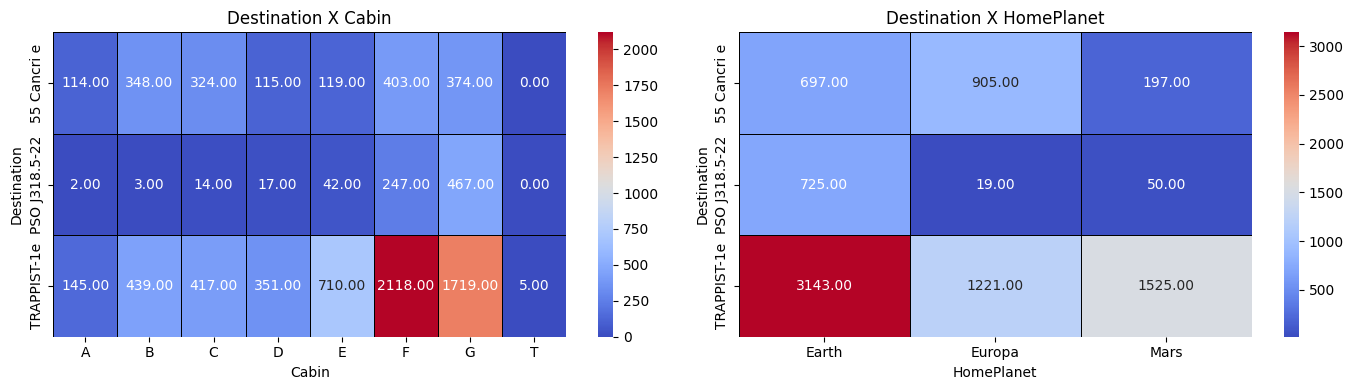

In [21]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (14, 4))
ax1, ax2 = axs.flatten()

#ax1
sns.heatmap(train.groupby("Destination")["Cabin"].value_counts().unstack().fillna(0), annot =True, fmt = ".2f", cmap = "coolwarm", linewidth = 0.5, linecolor = "black", ax=ax1)
ax1.set_title("Destination X Cabin")

#ax2
sns.heatmap(train.groupby("Destination")["HomePlanet"].value_counts().unstack(), annot =True, fmt = ".2f", cmap = "coolwarm", linewidth = 0.5, linecolor = "black", ax= ax2)
ax2.set_title("Destination X HomePlanet")

plt.tight_layout()
plt.show()

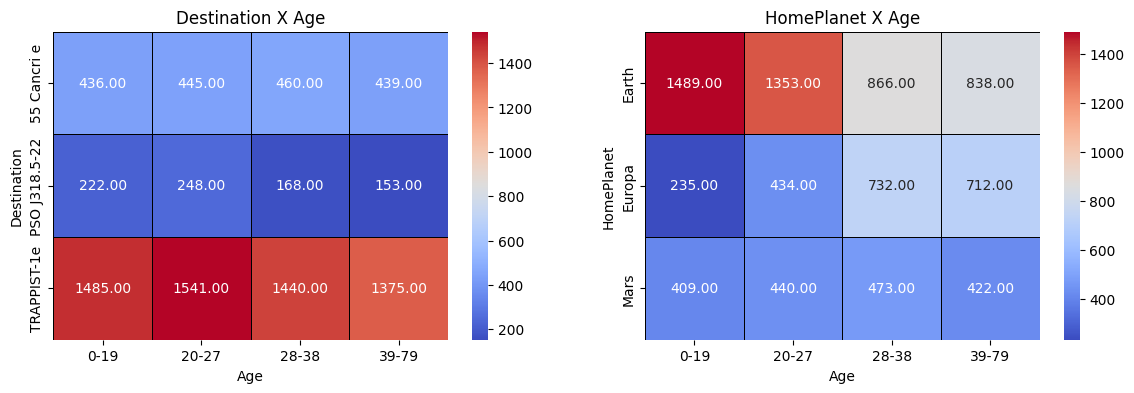

In [22]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (14, 4))
ax1, ax2 = axs.flatten()

#ax1
sns.heatmap(train.groupby("Destination")["Age"].value_counts().unstack(), annot =True, fmt = ".2f", cmap = "coolwarm", linewidth = 0.5, linecolor = "black", ax=ax1)
ax1.set_title("Destination X Age")

#ax2
sns.heatmap(train.groupby("HomePlanet")["Age"].value_counts().unstack(), annot =True, fmt = ".2f", cmap = "coolwarm", linewidth = 0.5, linecolor = "black", ax=ax2)
ax2.set_title("HomePlanet X Age")

plt.show()

I observed a strong correlation between **Cabin prefix and HomePlanet**:

* Passengers in cabins **A**, **B**, or **C** tend to come exclusively from **Europa**
* Passengers in cabin **G** are consistently from **Earth**

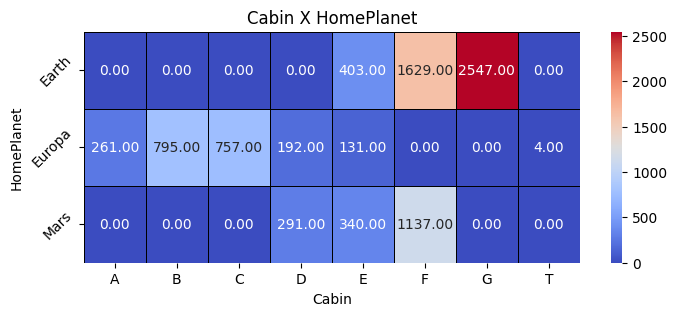

In [23]:
plt.figure(figsize = (8, 3))
sns.heatmap(train.groupby("HomePlanet")["Cabin"].value_counts().unstack().fillna(0), annot =True, fmt = ".2f", cmap = "coolwarm", linewidth = 0.5, linecolor = "black")
plt.title("Cabin X HomePlanet")
plt.yticks(rotation=45)
plt.show()

For passengers with missing **HomePlanet**, we can infer it based on their Cabin prefix:

* If Cabin starts with **A**, **B**, or **C**, assign **Europa**
* If Cabin starts with **G**, assign **Earth**

In [24]:
train.loc[train["HomePlanet"].isna() & (train["Cabin"].isin(["A","B","C","T"])), "HomePlanet"] = "Europa"
train.loc[train["HomePlanet"].isna() & (train["Cabin"].isin(["G"])), "HomePlanet"] = "Earth"


print(f'Remaining HomePlanet NaN: {train["HomePlanet"].isna().sum()}')

Remaining HomePlanet NaN: 63


For cabins **F**, **E**, and **D**, the distribution of HomePlanet is relatively uniform—no single planet dominates clearly.


> 📌 Because of this: I applied a **randomized imputation** strategy to fill missing HomePlanet values.

In [25]:
musk_CF = (train["Cabin"] == "F") & (train["HomePlanet"].isna())
musk_CE = (train["Cabin"] == "E") & (train["HomePlanet"].isna())
musk_CD = (train["Cabin"] == "D") & (train["HomePlanet"].isna())

train.loc[musk_CF, "HomePlanet"] = np.random.choice(["Earth","Mars"], size = musk_CF.sum(), replace = True)
train.loc[musk_CE, "HomePlanet"] = np.random.choice(["Earth","Mars"], size = musk_CE.sum(), replace = True)
train.loc[musk_CD, "HomePlanet"] = np.random.choice(["Europa","Mars"], size = musk_CD.sum(), replace = True)


print(f'Remaining HomePlanet NaN: {train["HomePlanet"].isna().sum()}')

Remaining HomePlanet NaN: 4


I filled the remaining NaN values using **the most frequent value within each group** to save time

In [26]:
fillD = train.groupby(["HomePlanet","Cabin","Age"])["Destination"].transform(lambda x: x.value_counts().idxmax() if x.notna().any() else np.nan)
train["Destination"] = train["Destination"].fillna(fillD)

print(f"Remaining Destination NaN: {train['Destination'].isna().sum()}")

Remaining Destination NaN: 3


In [27]:
fillA = train.groupby(["HomePlanet","Cabin","Destination"])["Age"].transform(lambda x: x.value_counts().idxmax() if x.notna().any() else np.nan)
train["Age"] = train["Age"].fillna(fillA)

print(f"Remaining Age NaN: {train['Age'].isna().sum()}")

Remaining Age NaN: 5


In [28]:
fillC = train.groupby(["HomePlanet","Destination","Age"])["Cabin"].transform(lambda x: x.value_counts().idxmax() if x.notna().any() else np.nan)
train["Cabin"] = train["Cabin"].fillna(fillC)

print(f"Remaining Cabin NaN: {train['Cabin'].isna().sum()}")

Remaining Cabin NaN: 10


**To fill missing values in the spending-related columns:**

* **RoomService**
* **FoodCourt**
* **ShoppingMall**
* **Spa**
* **VRDeck**

...**I grouped passengers based on shared characteristics:**

* **Cabin**
* **Age**
* **CryoSleep**

Within each group, I calculated the **median** for each spending column. Then, I used these medians **to fill the missing values (NaN) in their respective columns**.

In [29]:
train.groupby(["Cabin","Age","CryoSleep"]).median(numeric_only = True).round(2)

RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
Cabin Age   CryoSleep                                                         
A     0-19  False              0.0        0.0           0.0     0.0     0.0   
            True               0.0        0.0           0.0     0.0     0.0   
      20-27 False              0.0     1653.0           0.0   304.0   217.0   
            True               0.0        0.0           0.0     0.0     0.0   
      28-38 False              0.0     1298.0           0.0   214.0   588.0   
            True               0.0        0.0           0.0     0.0     0.0   
      39-79 False              0.0     1329.0           0.0   689.0   239.5   
            True               0.0        0.0           0.0     0.0     0.0   
B     0-19  False              0.0       22.0           0.0     0.0    69.0   
            True               0.0        0.0           0.0     0.0     0.0   
      20-27 False              0.0     1546.0           0.0   232.0   438.0   
            True               0.0        0.0           0.0     0.0     0.0   
      28-38 False              0.0     1935.0           0.0   330.5   698.0   
            True               0.0        0.0           0.0     0.0     0.0   
      39-79 False              0.0     1770.0           0.0   352.0   266.5   
            True               0.0        0.0           0.0     0.0     0.0   
C     0-19  False              0.0      329.0           0.0     0.0     4.0   
            True               0.0        0.0           0.0     0.0     0.0   
      20-27 False              0.0     1910.0           0.0   100.0  1012.0   
            True               0.0        0.0           0.0     0.0     0.0   
      28-38 False              0.0     1972.0           0.0   650.0   654.5   
            True               0.0        0.0           0.0     0.0     0.0   
      39-79 False              0.0     1813.0           0.0   514.0   607.5   
            True               0.0        0.0           0.0     0.0     0.0   
D     0-19  False            769.5        0.0         236.0     0.0     0.0   
            True               0.0        0.0           0.0     0.0     0.0   
      20-27 False            555.0        1.5          31.0    82.0     1.0   
            True               0.0        0.0           0.0     0.0     0.0   
      28-38 False            353.5        7.0          11.0    22.0     2.0   
            True               0.0        0.0           0.0     0.0     0.0   
      39-79 False            479.0        5.0          81.0    25.0     2.0   
            True               0.0        0.0           0.0     0.0     0.0   
E     0-19  False              2.0        0.0           5.0     0.0     0.0   
            True               0.0        0.0           0.0     0.0     0.0   
      20-27 False             12.0        1.0          14.0     5.0     1.0   
            True               0.0        0.0           0.0     0.0     0.0   
      28-38 False             44.0        7.0          24.5    13.0     2.5   
            True               0.0        0.0           0.0     0.0     0.0   
      39-79 False             44.0       13.5           7.0    14.5     7.0   
            True               0.0        0.0           0.0     0.0     0.0   
F     0-19  False              2.0        0.0           3.0     0.0     0.0   
            True               0.0        0.0           0.0     0.0     0.0   
      20-27 False             27.0        1.0          21.5     2.0     2.0   
            True               0.0        0.0           0.0     0.0     0.0   
      28-38 False            106.5        0.0          22.0     5.0     0.0   
            True               0.0        0.0           0.0     0.0     0.0   
      39-79 False            101.0        0.0          36.0     2.0     0.0   
            True               0.0        0.0           0.0     0.0     0.0   
G     0-19  False              0.0        0.0           0.0     0.0     0

In [30]:
group_CaAge = train.groupby(["Cabin","Age","CryoSleep"])[cols].transform("median")
train[cols] = train[cols].fillna(group_CaAge)

# We can even do something like this
for column in train[cols]:
    train.loc[train[column].isna() & train["CryoSleep"] == True, column] = 0.0 # Their Median

print(f'Remaining RoomService NaN: {train["RoomService"].isna().sum()}')
print(f'Remaining FoodCourt NaN: {train["FoodCourt"].isna().sum()}')
print(f'Remaining ShoppingMall NaN: {train["ShoppingMall"].isna().sum()}')
print(f'Remaining Spa NaN: {train["Spa"].isna().sum()}')
print(f'Remaining VRDeck NaN: {train["VRDeck"].isna().sum()}')

Remaining RoomService NaN: 0
Remaining FoodCourt NaN: 1
Remaining ShoppingMall NaN: 0
Remaining Spa NaN: 1
Remaining VRDeck NaN: 0


We’ve completed a **simple** yet effective **data cleaning process**

The workflow was:

* Fast and focused
* Guided by logical assumptions and data-driven insights

With a **well-prepared dataset** in hand, we’re now ready to move on to the **prediction phase** and start building models.

In [31]:
After_C = (train.drop(columns = ["Name","VIP","GroupID"]).dropna(how="any", axis = "index")).shape[0]
Total_NaN_A = train.isna().sum().sum()
Tot_NaN_WHT_A = train.drop(columns = ["Name","VIP"]).isna().sum().sum()

print("Samples Available:", train.shape[0])
print(f"Samples Missing For Prediction: {train.shape[0] - After_C}")
print("\nBefore Cleaning Ready For Prediction:", before_C)
print("After Cleaning Ready For Prediction: ", After_C)
print(f"Differance: {After_C - before_C}")
print("\nTotal NaN Before", Total_NaN_B)
print("Total NaN After", Total_NaN_A)
print("\nTotal NaN Before (Without Name & VIP):", Tot_NaN_WHT_B)
print("Total NaN After (Without Name & VIP):",    Tot_NaN_WHT_A)

Samples Available: 8693
Samples Missing For Prediction: 11

Before Cleaning Ready For Prediction: 6930
After Cleaning Ready For Prediction:  8682
Differance: 1752

Total NaN Before 2324
Total NaN After 427

Total NaN Before (Without Name & VIP): 1921
Total NaN After (Without Name & VIP): 24


In [32]:
After_C_S = train.drop(columns = "GroupID").isna().sum().values
tot = pd.DataFrame({"Colums": train.drop(columns="GroupID").isna().sum().index,"Before": Before_C_S, "After": After_C_S})
tot

,Colums,Before,After
0,PassengerId,0,0
1,HomePlanet,201,4
2,CryoSleep,217,0
3,Cabin,199,10
4,Destination,182,3
5,Age,179,5
6,VIP,203,203
7,RoomService,181,0
8,FoodCourt,183,1
9,ShoppingMall,208,0


# Prediction

**Let's import what we need!**

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.compose import ColumnTransformer

I'm performing a complete modeling workflow that starts with 
1. ...cleaning the dataset **by removing the remaining rows with missing values**.
2. Then, I define the features and the target variable, **excluding irrelevant columns**.
3. I build a **pipeline** that preprocesses categorical and numerical features appropriately—using one-hot encoding and scaling—and
4. ...then train a **Gradient Boosting Classifier** with some tuned parameters to improve prediction accuracy.

> I could have used **GridSearchCV** to optimize the model’s hyperparameters and potentially improve prediction performance. This technique systematically tests multiple combinations of parameters to find the best configuration. However, it can be **very time-consuming**, especially with complex models like Gradient Boosting. **To save time** and keep the workflow efficient, I've chosen to skip it.

In [34]:
train2 = train.dropna(axis = "index", how = "any").copy()

X = train2.drop(columns =["Name","VIP","Transported","PassengerId","GroupID"]).copy()
y = train2["Transported"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

pipe = Pipeline([
    ("prep", ColumnTransformer(transformers = [
        ("cat", OneHotEncoder(), ["HomePlanet","Age","Destination","Cabin"]),
        ("num", StandardScaler(), X.select_dtypes(include=["int", "float"]).columns)
    ])),
    ("model", GradientBoostingClassifier(random_state = 0, min_samples_leaf = 4, n_estimators = 150))
])


pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['HomePlanet', 'Age',
                                                   'Destination', 'Cabin']),
                                                 ('num', StandardScaler(),
                                                  Index(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object'))])),
                ('model',
                 GradientBoostingClassifier(min_samples_leaf=4,
                                            n_estimators=150,
                                            random_state=0))])

The prediction results are very strong, showing that the model is **performing well** on the task.

In [35]:
y_pred = pipe.predict(X_test)

print(f"Accuracy:       {accuracy_score(y_pred = y_pred, y_true = y_test):.2f}")
print(f"Precision:      {precision_score(y_pred = y_pred, y_true = y_test):.2f}")
print(f"Recall:         {recall_score(y_pred = y_pred, y_true = y_test):.2f}")
print(f"F1:             {f1_score(y_pred = y_pred, y_true = y_test):.2f}")

Accuracy:       0.80
Precision:      0.79
Recall:         0.84
F1:             0.81


I've created a **confusion matrix** because it provides a quick and clear summary of how well the model is classifying the data—showing both correct predictions and the types of errors it makes.

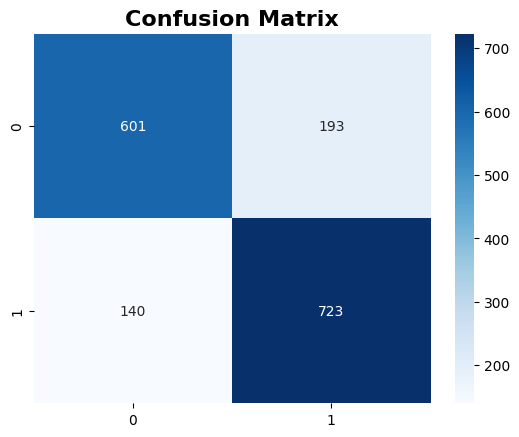

In [36]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix", fontdict = {"fontsize": 16, "weight":"bold"})
plt.show()

I've also created a second model using a **DecisionTreeClassifier** to compare its performance with the Gradient Boosting model.

In [37]:
pipe2 = Pipeline([
    ("prep", ColumnTransformer(transformers = [
        ("cat", OneHotEncoder(), ["HomePlanet","Age","Destination","Cabin"]),
        ("num", StandardScaler(), X.select_dtypes(include=["int", "float"]).columns)
    ])),
    ("model", DecisionTreeClassifier(random_state = 0))
])

pipe2.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['HomePlanet', 'Age',
                                                   'Destination', 'Cabin']),
                                                 ('num', StandardScaler(),
                                                  Index(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object'))])),
                ('model', DecisionTreeClassifier(random_state=0))])

This allows for a more meaningful evaluation using the **ROC curve**, which visually compares how well each model distinguishes between classes. By plotting both models on the same ROC curve, I can assess which one offers better classification performance in terms of sensitivity and specificity.

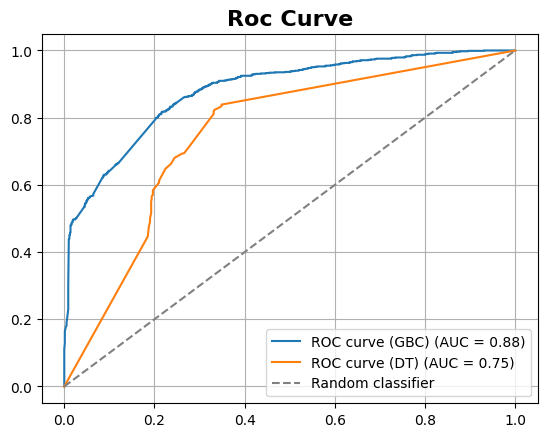

In [38]:
y_scores = pipe.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

y_scores2 = pipe2.predict_proba(X_test)[:, 1]
fpr2, tpr2, _ = roc_curve(y_test, y_scores2)
roc_auc2 = auc(fpr2, tpr2)

plt.plot(fpr, tpr, label = f'ROC curve (GBC) (AUC = {roc_auc:.2f})')

plt.plot(fpr2, tpr2, label = f'ROC curve (DT) (AUC = {roc_auc2:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random classifier')
plt.title("Roc Curve", fontdict = {"fontsize": 16, "weight": "bold"})
plt.legend()
plt.grid(True)
plt.show()

I've also created a **countplot** to visualize the distribution of the predicted classes. This helps to quickly understand whether the model is biased toward one class or if the predictions are balanced. By plotting the frequency of each predicted label, I can assess how the model is behaving and whether it's favoring one outcome over the other

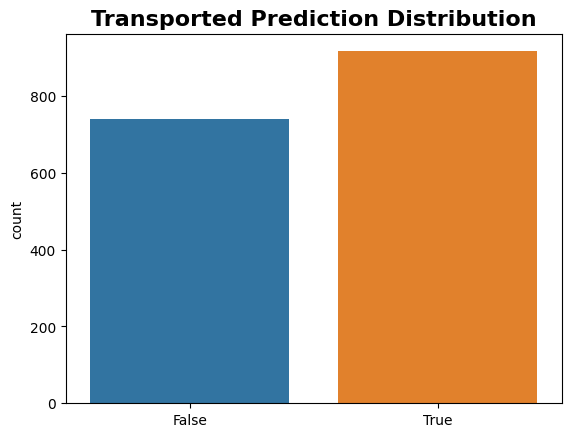

In [39]:
sns.countplot(x=pd.Series(y_pred))
plt.title("Transported Prediction Distribution", fontdict = {"fontsize": 16, "weight": "bold"})
plt.show()